## This is a notebook for computing MPF using AMSR-E brightness temperature

author: Kexin Song
Date: 09/05/2019

In [1]:
import numpy as np
# from pyhdf import SD
import xarray as xr
import glob

### Frist, Load brightness temperature (TB) datasets

In [2]:
ds = xr.open_dataset("AMSR_E_L3_SeaIce25km_V15_20080701.hdf")
TB06H = ds.SI_25km_NH_06H_DAY
TB89V = ds.SI_25km_NH_89V_DAY

In [ ]:
## I am also tring to access dataset via Earthdata...
from pydap.client import open_url
from pydap.cas.urs import setup_session
url = 'https://acdisc.gesdisc.eosdis.nasa.govacdis/opendap/HDF-EOS5/Aura_MLS_Level2/ML2BRO.004/2016/MLS-Aura_L2GP-BrO_v04-23-c03_2016d303.he5'
session = setup_session('Kexin.Song', 'Kathy-mao3gou4') # Use yours here.
url = 'https://acdisc.gesdisc.eosdis.nasa.govacdis/opendap/HDF-EOS5/Aura_MLS_Level2/ML2BRO.004/2016/MLS-Aura_L2GP-BrO_v04-23-c03_2016d303.he5'
dataset = open_url(url, session=session)

In [ ]:
from pydap.client import open_url
from pydap.cas.urs import setup_session

url = 'https://n5eil01u.ecs.nsidc.org/AMSA/AE_SI25.003/2008.07.01/AMSR_E_L3_SeaIce25km_V15_20080701.hdf.xml'

session = setup_session(username = 'Kexin.Song', password = 'Kathy-mao3gou4', check_url=url)

ds = open_url(url, session=session)
ds

### Now, load 25km land mask

In [3]:
ds = xr.open_dataset("amsr_gsfc_25n.hdf")
lm = ds.landmask
lm

<xarray.DataArray 'landmask' (fakeDim0: 448, fakeDim1: 304)>
[136192 values with dtype=uint8]
Dimensions without coordinates: fakeDim0, fakeDim1

### Let's look at the TB data

<xarray.DataArray 'SI_25km_NH_06H_DAY' (YDim:NpPolarGrid25km: 448, XDim:NpPolarGrid25km: 304)>
array([[ 889,  882,  883, ..., 2648, 2650, 2664],
       [ 891,  882,  881, ..., 2648, 2657, 2678],
       [ 893,  883,  881, ..., 2649, 2664, 2681],
       ...,
       [2892, 2835, 2822, ...,  835,  834,  833],
       [2877, 2844, 2829, ...,  834,  834,  832],
       [2875, 2827, 2818, ...,  835,  833,  830]], dtype=int16)
Dimensions without coordinates: YDim:NpPolarGrid25km, XDim:NpPolarGrid25km

In [4]:
tb06h = TB06H.values * 0.1
print(tb06h.min(),tb06h.mean(),tb06h.max())

tb89v = TB89V.values * 0.1
print(tb89v.min(),tb89v.mean(),tb89v.max())


0.0 179.40187235667292 308.1
0.0 262.1835842046523 306.1


In [5]:
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
def make_map(projection, figsize):
    fig, ax = plt.subplots(
        figsize=figsize,
        subplot_kw={"projection": projection})
    return fig, ax

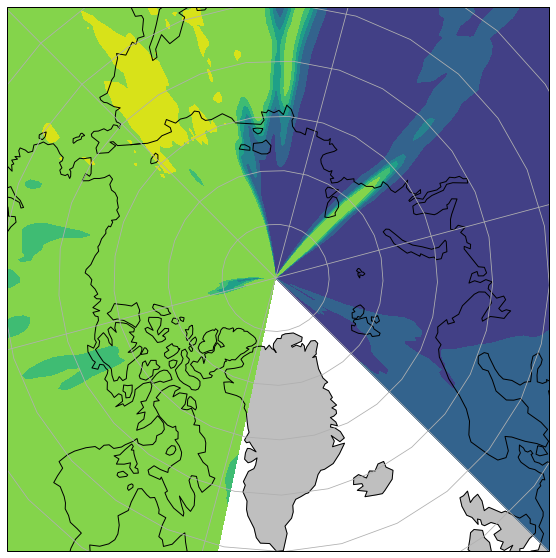

In [49]:
fig, ax = make_map(projection=ccrs.NorthPolarStereo(central_longitude = -45), figsize=(10,10))

ax.set_extent([-179, 180, 60, 90], ccrs.PlateCarree())
ax.coastlines(resolution="110m", color="k")
ax.add_feature(cfeature.LAND, facecolor="0.75")
ax.gridlines()

ax.contourf(tb06h,transform = ccrs.PlateCarree())

In [ ]:

## rebin TB89Vm to 25km
import rebin
TB89Vr = rebin.rebin(TB89Vm,(2,2))

## mask TB89Vr
TB89Vrm = np.ma.MaskedArray(TB89Vr,lm25)

print(TB89Vm.mean(),TB89Vrm.mean())


## calculate MPF
add = TB06H + TB89Vrm
dif = TB06H - TB89Vrm
mpf = 15.2 - (158.9*dif/add)

from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

## plot mpf
plt.figure(figsize=(8,8))
#mpf[mpf<0] = np.nan
#mpfm = np.ma.masked_invalid(mpf)
plt.imshow(mpf)
#plt.imshow(mpfm)
plt.colorbar()

## plot 1-mpf
plt.figure(figsize=(8,8))
plt.imshow(100-mpf,cmap="gist_ncar")
plt.colorbar()

## plot absolute mpf = mpf/95 (assume sic=95%)
mpfa = mpfm/95*100
plt.figure(figsize=(8,8))
plt.imshow(mpfa)
plt.colorbar()

## plot 1- absolute mpf
plt.figure(figsize=(8,8))
plt.imshow(100-mpfa,cmap="gist_ncar")
plt.colorbar()

## plot (1-mpf)-(1-absolute mpf)
plt.figure(figsize=(8,8))
d = mpfa-mpf
print(d.min(),d.mean(),d.max())

d[d>2] = np.nan
dm = np.ma.masked_invalid(d)

plt.imshow(dm)
plt.colorbar()